## Gender Prediction with a Logitic Regression in Apache Spark

Authors: David Tang, Karmveer Sidhu, Waley Chen

This is an implementation of a LR model in Apache Spark to classify gender in our IMDb data set. The primary dependencies are from skimage libary for image filtering and feature extraction.

# Start up Spark Cluster

In [1]:
import os
import atexit
import sys

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
import findspark
from sparkhpc import sparkjob

#Exit handler to clean up the Spark cluster if the script exits or crashes
def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass

findspark.init()

#Parameters for the Spark cluster
nodes=5
tasks_per_node=8 
memory_per_task=1024 #1 gig per process, adjust accordingly
# Please estimate walltime carefully to keep unused Spark clusters from sitting 
# idle so that others may use the resources.
walltime="2:00" #2 hour
os.environ['SBATCH_PARTITION']='cpu2019' #Set the appropriate ARC partition

sj = sparkjob.sparkjob(
     ncores=nodes*tasks_per_node,
     cores_per_executor=tasks_per_node,
     memory_per_core=memory_per_task,
     walltime=walltime
    )

sj.wait_to_start()
sc = sj.start_spark()

#Register the exit handler                                                                                                     
atexit.register(exitHandler,sj,sc)

#You need this line if you want to use SparkSQL
sqlCtx=SQLContext(sc)

INFO:sparkhpc.sparkjob:Submitted batch job 692291

INFO:sparkhpc.sparkjob:Submitted cluster 0
INFO:sparkhpc.sparkjob:


SystemExit: 0

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
imgDir = "Images/100x100-10K/" # directory of images
labelsFile = "../Project/Images/genders_data_10k.json" # file that contains data on images

In [ ]:
# Creates a Spark Dataframe
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('df').getOrCreate()

df = spark.read.format("image").option("dropInvalid", "true").load(imgDir)
df.createOrReplaceTempView("Images")

In [ ]:
df.printSchema()
rdd = df.rdd.map(list)

# query = """SELECT image.* FROM Images WHERE image.height<>100"""
# sqlCtx.sql(query).show()

In [ ]:
# dependencies

import numpy as np
import skimage
from skimage.io import imread, imshow
from skimage.feature import canny, daisy, hog
from skimage.feature import peak_local_max
from skimage import img_as_float
from scipy import ndimage as ndi
from skimage.feature import shape_index
from mpl_toolkits.mplot3d import Axes3D

from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters.rank import median
from skimage.filters.rank import mean
from skimage import exposure
from skimage.filters import rank
from skimage.filters import gaussian

import json

In [ ]:
# Reads in images as grey instead of their default which spark does
def image_reader(x):
    img_path = x[0].origin
    img = imread(img_path, as_gray = True)
    return (img_path, img)
img_rdd = rdd.map(image_reader)

In [ ]:
def daisy_convert(x):
    '''DAISY feature extraction'''
    img_path = x[0]
    try:
        img = daisy(x[1], step=50, radius=45, 
                    rings=2, histograms=8,orientations=8)
    except:
        return (None, None)
    return (img_path, img)

def canny_convert(x):
    '''Canny Feature Extraction'''
    img_path = x[0]
    try:
        img = canny(x[1])
    except:
        return (None, None)
    return (img_path, img)

def hog_convert(x):
    '''Histogram of Oriented Gradients feature extraction'''
    img_path = x[0]
    try:
        img = hog(x[1], orientations=8, 
                  pixels_per_cell=(20, 20),cells_per_block=(1, 1))
    except:
        return (None, None)
    return (img_path, img)

def peak_max_convert(x):
    '''
    TESTING ONLY NOT USED IN PROJECT
    Peak Max Feature extraction. 
    '''
    img_path = x[0]
    try:
        img_loc_max = img_as_float(x[1])
        img = ndi.maximum_filter(img_loc_max, size=5, mode='constant')
        coordinates = peak_local_max(img_loc_max, min_distance=8)
    except:
        return (None, None)
    return (img_path, coordinates)
    
def shape_index_convert(x):
    '''
    TESTING ONLY NOT USED IN PROJECT
    Shape Index Feature extraction. 
    '''
    img_path = x[0]
    try:
        img = shape_index(x[1])
    except:
        return (None, None)
    return (img_path, img)

def entropy_convert(x):
    '''Entropy Feature Extraction'''
    img_path = x[0]
    try:
        img = entropy(x[1],disk(1))
    except:
        return (None, None)
    return (img_path, img)

def extract_features(x):
    '''Extracts features and flattens array'''
    daisy = daisy_convert(x)[1].flatten()
    canny = canny_convert(x)[1].flatten()
    hog = hog_convert(x)[1].flatten()
    entropy = entropy_convert(x)[1].flatten()
    peak_max = peak_max_convert(x)[1].flatten() # Not giving right amount of features
    shape_index = shape_index_convert(x)[1].flatten() # Not giving right amount of features
#     return (x[0], x[1]) # Original Images
    return (x[0], daisy, canny) # Can change what features it returns to test different combinations

def flatten_array(x):
    # Flattens Array from a NxM array to a list of length N*M
    flattened = []
    for arr in x[1:]:
        for val in arr.flatten():
            flattened.append(val)
    return (x[0],len(flattened),flattened)

def preprocess_images(x):
    # Preprocessing Techniques used on images
    img_path = x[0]
    try:
        img = median(exposure.equalize_hist(gaussian(x[1],1)),disk(1))
    except:
        return (None, None)
    return (img_path, img)

def aws_label_features(x):
    lbl_dict[x[0].split("/")[-1]]["FaceDetails"][0]["Landmarks"][0]


In [ ]:
img_features = img_rdd.map(preprocess_images).map(extract_features).map(flatten_array)

In [ ]:
with open(labelsFile, "r") as f:
    gender_dict = json.load(f)

In [ ]:
from pyspark.mllib.regression import LabeledPoint
classified_imgs = img_features.map(lambda x: LabeledPoint(gender_dict[x[0].split("/")[-1]]["Actual"], x[2]))
test, train = classified_imgs.randomSplit(weights=[0.25, 0.75], seed=1)

## SVM
Not utilized in study as it is linear and it was found that it does not do a sufficent job of classifying gender

In [120]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel

# Build the model
svmModel = SVMWithSGD.train(train, iterations=1)
print("Model built")

Model built


In [121]:
# Evaluating the model on training data
trainLabelsAndPreds = train.map(lambda p: (p.label, svmModel.predict(p.features)))
trainErr = trainLabelsAndPreds.filter(lambda v: v[0] != v[1]).count() / float(train.count())
# Evaluating the model on test data
testLabelsAndPreds = test.map(lambda p: (p.label, svmModel.predict(p.features)))
testErr = testLabelsAndPreds.filter(lambda v: v[0] != v[1]).count() / float(test.count())

In [122]:
print("SVM")
print(f"Training Error = {trainErr*100}%")
print(f"Test Error = {testErr*100}%")


SVM
Training Error = 37.77490297542044%
Test Error = 38.32599118942731%


In [18]:
svmModel.save(sc, "svmModel-daisy-canny")
# sameModel = SVMModel.load(sc, "target/tmp/pythonSVMWithSGDModel")

## Logistic Regression

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
import time
start = time.time()

#Build Model
lrModel = LogisticRegressionWithLBFGS.train(train)
print("Model built")

In [ ]:
# Evaluating the model on training data
lrTrainLabelsAndPreds = train.map(lambda p: (p.label, lrModel.predict(p.features)))
lrTrainErr = lrTrainLabelsAndPreds.filter(lambda v: v[0] != v[1]).count() / float(train.count())
# Evaluating the model on testing data
lrTestLabelsAndPreds = test.map(lambda p: (p.label, lrModel.predict(p.features)))
lrTestErr = lrTestLabelsAndPreds.filter(lambda v: v[0] != v[1]).count() / float(test.count())

end = time.time()

In [ ]:
print("Logistic Regression")
print(f"Training Error = {lrTrainErr*100}%")
print(f"Test Error = {lrTestErr*100}%")
print(f"{end - start} seconds {nodes} nodes")

In [51]:
lrModel.save(sc, "lrModel-")
# sameModel = SVMModel.load(sc, "target/tmp/pythonSVMWithSGDModel")

NameError: name 'sc' is not defined

## Get Model Metrics

In [118]:
f_name = "LabelsAndPredicted/10K/lrResults-test-original.csv"
act_pred_list = lrTestLabelsAndPreds.collect()

In [119]:
def write_labels_and_pred_to_file(f_name, act_pred_list):
    with open(f_name, "w") as f:
        f.write("actual,pred\n")
        for x in act_pred_list:   
            f.write(str(x[0]) + "," + str(x[1]) + "\n")

write_labels_and_pred_to_file(f_name, act_pred_list)
print("Written to file.")

Written to file.


# Below is Testing Different Feature Extraction Techniques

In [76]:
test = img_rdd.take(100)[75][1]

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
test

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.0551698 , 0.03556196,
        0.01987569],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.05909137, 0.0434051 ,
        0.03164039],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.0434051 , 0.02771882,
        0.01987569],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02296392, 0.02296392,
        0.02296392],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00363882, 0.00363882,
        0.00363882],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00727765, 0.00727765,
        0.00727765]])

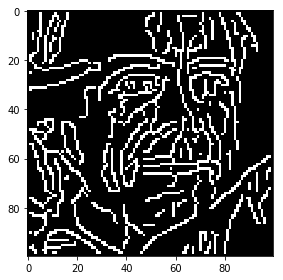

In [77]:
imshow(canny(test))

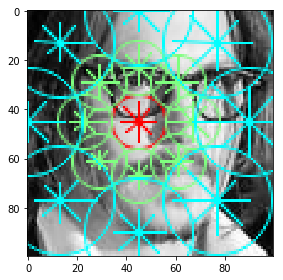

In [63]:
daisy1, daisy_vis = daisy(test,step=50, radius=45, rings=2, histograms=8,orientations=8,visualize = True)
imshow(daisy_vis)

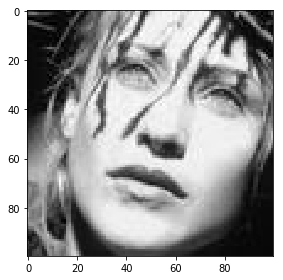

In [75]:
imshow(test)

In [32]:
daisy1

array([[[0.00767423, 0.00849125, 0.00824427, 0.0074796 , 0.00830765,
         0.00942236, 0.00988974, 0.00740091, 0.01183462, 0.01081946,
         0.00892089, 0.00916558, 0.01180166, 0.01146061, 0.01012412,
         0.00950266, 0.00707759, 0.00770888, 0.00714488, 0.00680664,
         0.00755266, 0.00813566, 0.00785947, 0.00632445, 0.00437072,
         0.00557534, 0.00596324, 0.00579788, 0.00611481, 0.00624246,
         0.00618227, 0.00455504, 0.00501075, 0.00459541, 0.00448819,
         0.00641795, 0.00844694, 0.00635367, 0.0044979 , 0.0043726 ,
         0.00667574, 0.00537583, 0.00485703, 0.00746239, 0.01048946,
         0.00802969, 0.00561456, 0.00564825, 0.00709476, 0.00691943,
         0.00719425, 0.007923  , 0.01019722, 0.00975054, 0.00822826,
         0.00682758, 0.00595816, 0.00780746, 0.009963  , 0.00856908,
         0.00837965, 0.00891416, 0.00820101, 0.00589554, 0.00957057,
         0.01057299, 0.01088507, 0.00939477, 0.01026606, 0.01035827,
         0.00951958, 0.00823141, 0

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


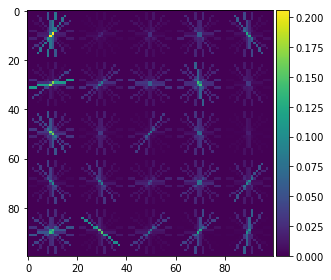

In [79]:
hog_test, hog_vis = hog(test, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize= True)
imshow(hog_vis)

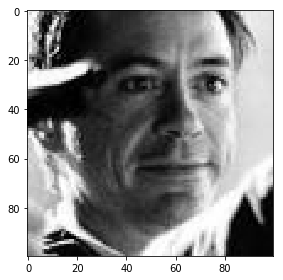

In [78]:
imshow(test)

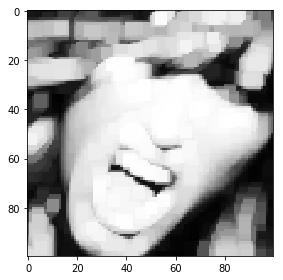

In [37]:
img_loc_max = img_as_float(test)
img_max = ndi.maximum_filter(img_loc_max, size=5, mode='constant')
imshow(img_max)

In [38]:
coordinates = peak_local_max(img_loc_max, min_distance=8)

Text(0.5,1,'Peak local max')

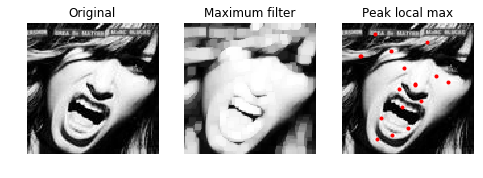

In [39]:

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(img_loc_max, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(img_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(img_loc_max, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

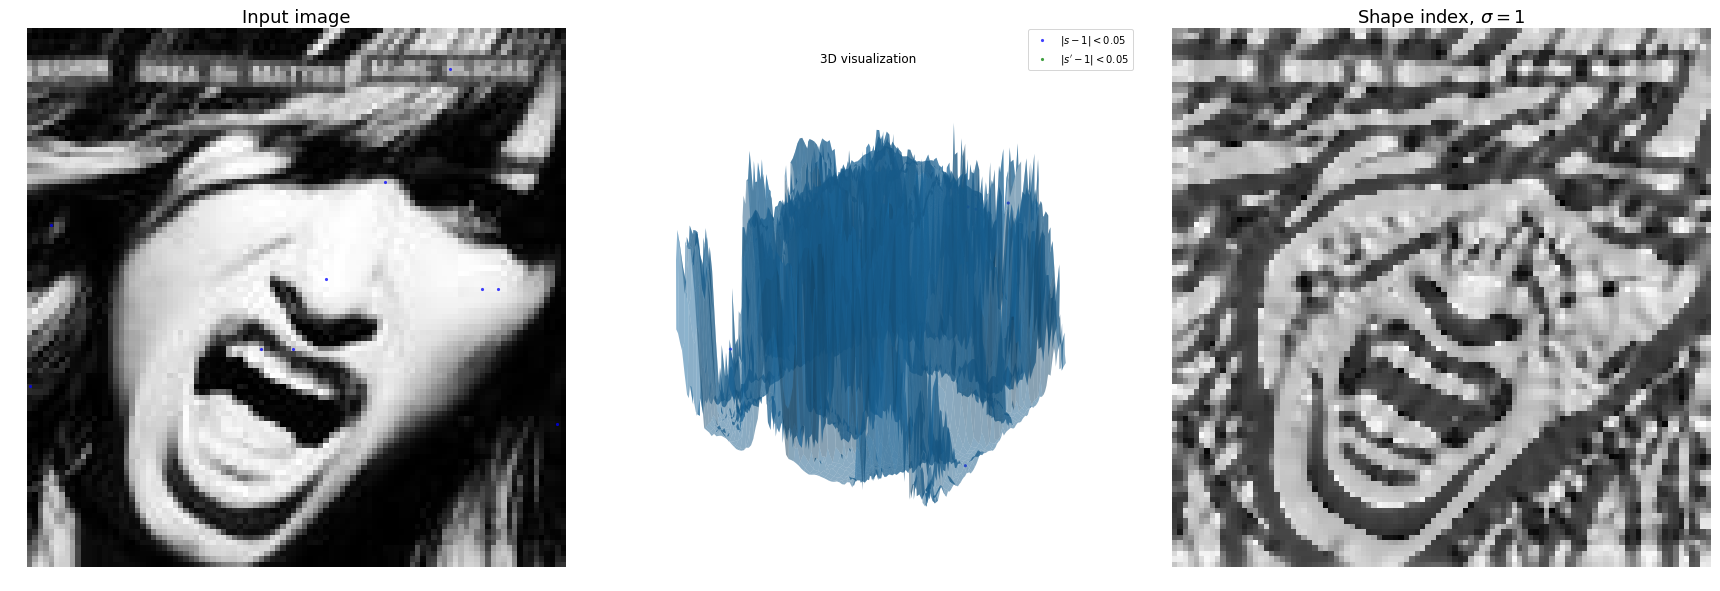

In [40]:
s = shape_index(test)

# In this example we want to detect 'spherical caps',
# so we threshold the shape index map to
# find points which are 'spherical caps' (~1)

target = 1
delta = 0.05

point_y, point_x = np.where(np.abs(s - target) < delta)
point_z = test[point_y, point_x]
s_smooth = ndi.gaussian_filter(s, sigma=0.5)

point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
point_z_s = test[point_y_s, point_x_s]

# Vis ------

fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(1, 3, 1)

ax1.imshow(test, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Input image', fontsize=18)

scatter_settings = dict(alpha=0.75, s=10, linewidths=0)

ax1.scatter(point_x, point_y, color='blue', **scatter_settings)
ax1.scatter(point_x_s, point_y_s, color='green', **scatter_settings)

ax2 = fig.add_subplot(1, 3, 2, projection='3d', sharex=ax1, sharey=ax1)

x, y = np.meshgrid(
    np.arange(0, test.shape[0], 1),
    np.arange(0, test.shape[1], 1)
)

ax2.plot_surface(x, y, test, linewidth=0, alpha=0.5)

ax2.scatter(
    point_x,
    point_y,
    point_z,
    color='blue',
    label='$|s - 1|<0.05$',
    **scatter_settings
)

ax2.scatter(
    point_x_s,
    point_y_s,
    point_z_s,
    color='green',
    label='$|s\' - 1|<0.05$',
    **scatter_settings
)

ax2.legend()

ax2.axis('off')
ax2.set_title('3D visualization')

ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax3.imshow(s, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Shape index, $\sigma=1$', fontsize=18)

fig.tight_layout()

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


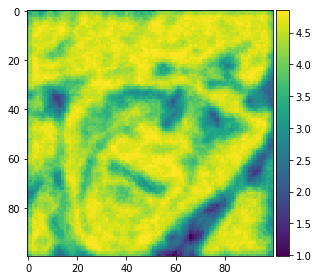

In [57]:

imshow(entropy(test, disk(3)))

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


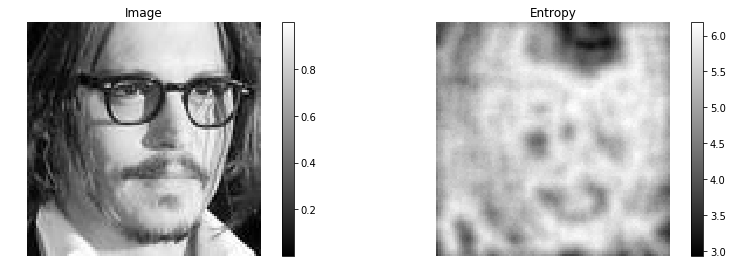

In [85]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(test, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(test, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


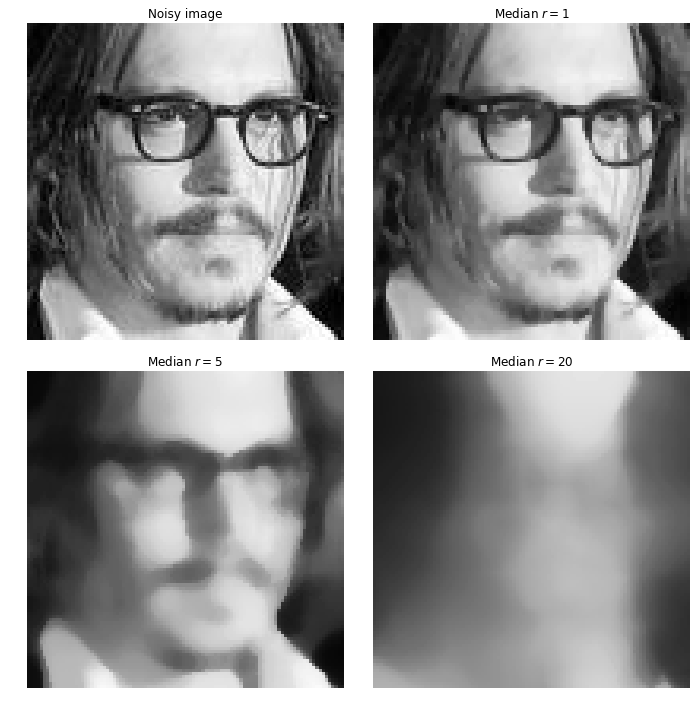

In [86]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(test, cmap=plt.cm.gray)
ax[0].set_title('Noisy image')

ax[1].imshow(median(test, disk(1)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('Median $r=1$')

ax[2].imshow(median(test, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('Median $r=5$')

ax[3].imshow(median(test, disk(20)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('Median $r=20$')

for a in ax:
    a.axis('off')

plt.tight_layout()


/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


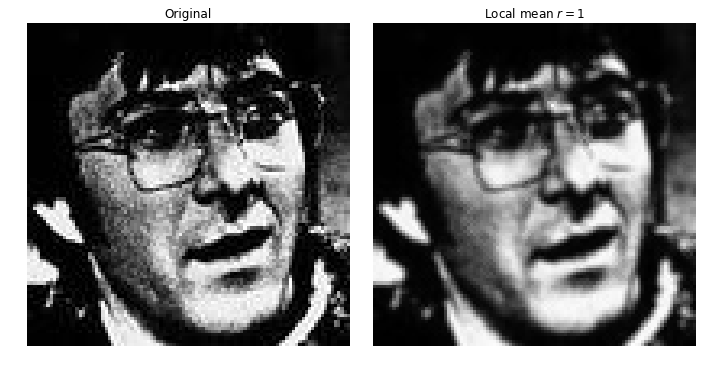

In [79]:

loc_mean = mean(test, disk(10))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(test, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(mean(test, disk(1)), cmap=plt.cm.gray)
ax[1].set_title('Local mean $r=1$')

for a in ax:
    a.axis('off')

plt.tight_layout()

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


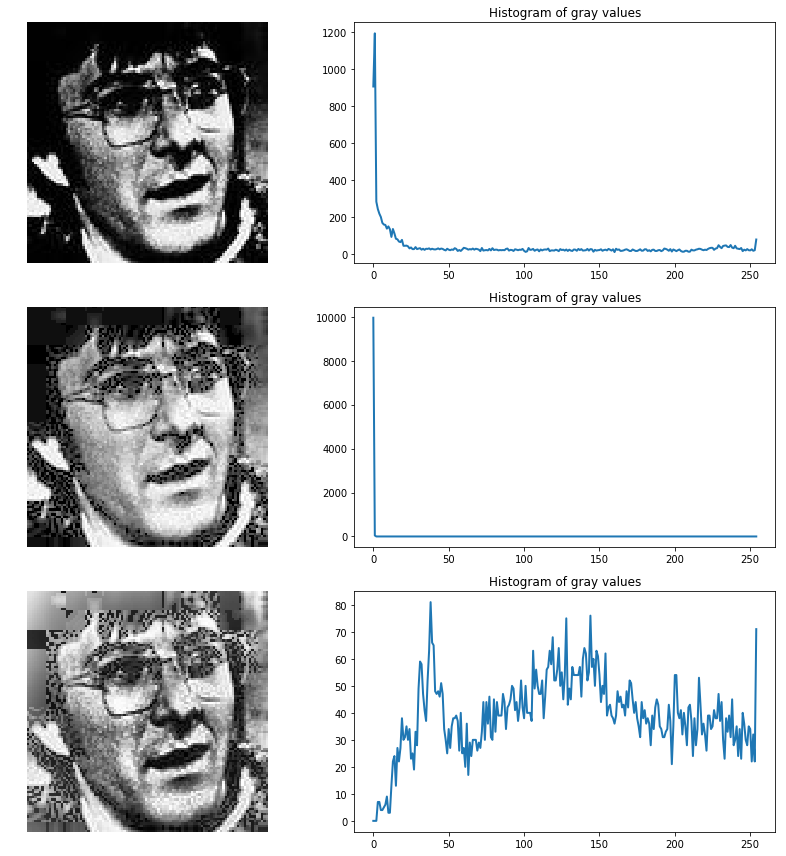

In [84]:

noisy_image = img_as_ubyte(test)

# equalize globally and locally
glob = exposure.equalize_hist(test)
loc = rank.equalize(test, disk(20))

# extract histogram for each image
hist = np.histogram(noisy_image, bins=np.arange(0, 256))
glob_hist = np.histogram(glob, bins=np.arange(0, 256))
loc_hist = np.histogram(loc, bins=np.arange(0, 256))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
ax = axes.ravel()

ax[0].imshow(test, interpolation='nearest', cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].plot(hist[1][:-1], hist[0], lw=2)
ax[1].set_title('Histogram of gray values')

ax[2].imshow(glob, interpolation='nearest', cmap=plt.cm.gray)
ax[2].axis('off')

ax[3].plot(glob_hist[1][:-1], glob_hist[0], lw=2)
ax[3].set_title('Histogram of gray values')

ax[4].imshow(loc, interpolation='nearest', cmap=plt.cm.gray)
ax[4].axis('off')

ax[5].plot(loc_hist[1][:-1], loc_hist[0], lw=2)
ax[5].set_title('Histogram of gray values')

plt.tight_layout()

In [84]:
test = img_rdd.take(100)[20][1]

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


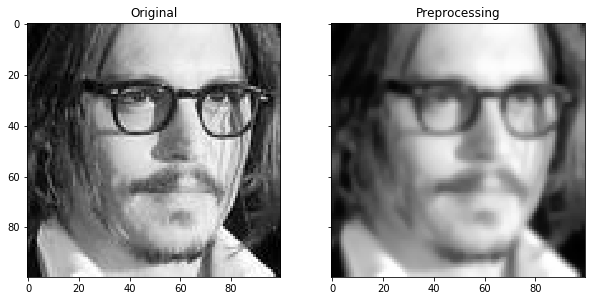

In [62]:
from skimage import data, exposure, img_as_float
import numpy as np

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(test, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(median(exposure.equalize_hist(gaussian(test,1)),disk(1)), cmap=plt.cm.gray)
ax[1].set_title('Preprocessing')

fig.savefig(fname="og-vs-pp-3", dpi=300)


/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Text(0.5,1,'histogram of gray values')

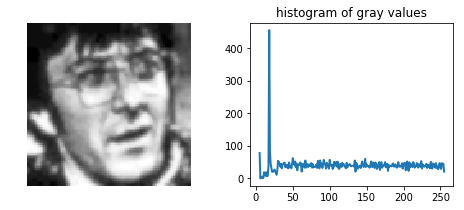

In [34]:
from skimage import data, exposure, img_as_float
import numpy as np
img = median(exposure.equalize_hist(gaussian(test,1)),disk(1))
hist, hist_centers = exposure.histogram(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')